In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from gridworld import GridWorld
from mdp import MDP

### Set up Gridworld with walls, wind, and friction

In [2]:
GAMMA = 0.9

gridworld = GridWorld(
    7, 7, 
    #wall_horiz=[[0, 1],[1, 2], [2, 3]], 
    #wall_vert=[[1, 1], [2, 2], [3, 3]],
    wall_vert= [[2, 1]],
    controllability=[0.6, 0.6], 
    wind=[-0.5, 0.0])

print("GridWorld:")
print(gridworld.grid)

GridWorld:
x―x―x―x―x―x―x―x
|             |
x x x x x x x x
|             |
x x x x x x x x
|             |
x x x x x x x x
|             |
x x x x x x x x
|             |
x x x x x x x x
|   |         |
x x x x x x x x
|             |
x―x―x―x―x―x―x―x



### Calculate affordance rates for the system

Controllability matrix C(s,s'):


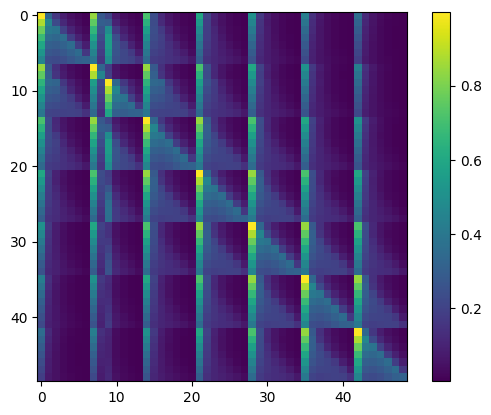

Affordance rate of states:


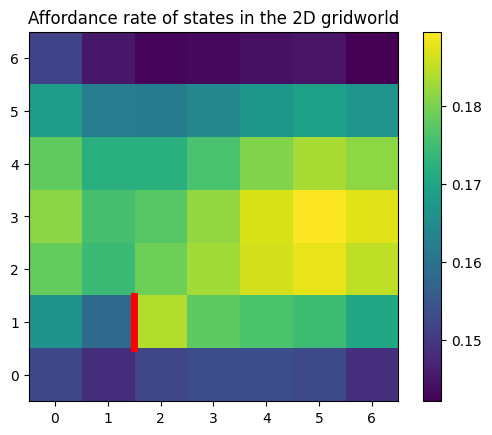

Affordance rate of overall system:
tensor(0.1681)


In [3]:
TPM = gridworld.get_TPM()
C = torch.zeros((gridworld.n_states, gridworld.n_states), dtype=torch.float32)

# Calculate the controllability matrix C(s,s') for each state
for i in range(gridworld.n_states):
    rewards = torch.zeros(gridworld.n_states)
    rewards[i] = 1.0
    mdp = MDP(TPM, rewards, gamma=GAMMA)
    mdp.get_SR_M()
    M = mdp.M
    M *= (1 - GAMMA) # normalise the successor representation
    C[:, i] = M[:, i]

# Plot results
print("Controllability matrix C(s,s'):")
plt.imshow(C.numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

print("Affordance rate of states:")
c_bar = torch.mean(C, dim=1)
# wrap onto grid to show controllability of states
c_bar_grid = c_bar.reshape(gridworld.height, gridworld.width)

plt.imshow(c_bar_grid.numpy(), cmap='viridis', interpolation='nearest')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Affordance rate of states in the 2D gridworld")

# draw walls from the gridworld
if gridworld.wall_horiz is not None:
    for wall in gridworld.wall_horiz:
        plt.plot([wall[0]-0.5, wall[1]-0.5], [wall[0]+0.5, wall[0]+0.5], color='red', linewidth=5)
if gridworld.wall_vert is not None:
    for wall in gridworld.wall_vert:
        plt.plot([wall[0]-0.5, wall[0]-0.5], [wall[1]-0.5, wall[1]+0.5], color='red', linewidth=5)

plt.show()

print("Affordance rate of overall system:")
c_bar_bar = torch.mean(C)
print(c_bar_bar)